In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Change directory to the desired location in Google Drive
import os
os.chdir('/content/gdrive/MyDrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Read the CSV file
df = pd.read_csv("/content/gdrive/MyDrive/Ocular_Disease_Recognition/full_df.csv")
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
df[df.C==1].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
65,81,66,Male,81_left.jpg,81_right.jpg,moderate non proliferative retinopathy，cataract,moderate non proliferative retinopathy，cataract,0,1,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",81_right.jpg
86,103,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",103_right.jpg
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [ ]:
df[df == 1].sum(axis=0)

ID                              2.0
Patient Age                    28.0
Patient Sex                       0
Left-Fundus                       0
Right-Fundus                      0
Left-Diagnostic Keywords          0
Right-Diagnostic Keywords         0
N                            2101.0
D                            2123.0
G                             397.0
C                             402.0
A                             319.0
H                             203.0
M                             306.0
O                            1588.0
filepath                          0
labels                            0
target                            0
filename                          0
dtype: object

In [ ]:
df2 = df.iloc[:, 1:7]
df2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [ ]:
df2[df2['Left-Diagnostic Keywords'].str.match('cataract')].head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
86,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus
100,59,Male,119_left.jpg,119_right.jpg,cataract,drusen
218,60,Female,254_left.jpg,254_right.jpg,cataract,macular epiretinal membrane
256,69,Female,294_left.jpg,294_right.jpg,cataract,normal fundus


In [ ]:
df_left_c = df2[df2['Left-Diagnostic Keywords'].str.match('cataract')]
print(len(df_left_c))

294


In [ ]:
df_rt_c = df2[df2['Right-Diagnostic Keywords'].str.match('cataract')]
print(len(df_rt_c))

278


In [ ]:
df_left_n = df2[df2['Left-Diagnostic Keywords'].str.match('normal')]
print(len(df_left_n))

2855


In [ ]:
df_rt_n = df2[df2['Right-Diagnostic Keywords'].str.match('normal')]
print(len(df_rt_n))

2735


In [ ]:
df[df['Left-Diagnostic Keywords'].str.match('cataract')].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
86,103,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",103_right.jpg
100,119,59,Male,119_left.jpg,119_right.jpg,cataract,drusen,0,0,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",119_right.jpg
218,254,60,Female,254_left.jpg,254_right.jpg,cataract,macular epiretinal membrane,0,0,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",254_right.jpg
256,294,69,Female,294_left.jpg,294_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",294_right.jpg


In [ ]:
df[df['Right-Diagnostic Keywords'].str.match('cataract')].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg
160,188,55,Female,188_left.jpg,188_right.jpg,laser spot，severe proliferative diabetic retin...,cataract,0,1,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",188_right.jpg
186,218,36,Female,218_left.jpg,218_right.jpg,refractive media opacity,cataract,0,0,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",218_right.jpg
309,354,65,Male,354_left.jpg,354_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",354_right.jpg


In [ ]:
df_c_files = df_left_c['Left-Fundus'].append(df_rt_c['Right-Fundus'], ignore_index=True)
df_c_files.head()

<ipython-input-15-415f96e235d4>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_c_files = df_left_c['Left-Fundus'].append(df_rt_c['Right-Fundus'], ignore_index=True)


0      0_left.jpg
1    103_left.jpg
2    119_left.jpg
3    254_left.jpg
4    294_left.jpg
dtype: object

In [ ]:
len(df_c_files)

572

In [ ]:
df_c_files.head()

0      0_left.jpg
1    103_left.jpg
2    119_left.jpg
3    254_left.jpg
4    294_left.jpg
dtype: object

In [ ]:
df_c_files.tail()

567    2243_right.jpg
568    2246_right.jpg
569    2247_right.jpg
570    2248_right.jpg
571    2282_right.jpg
dtype: object

In [ ]:
dataset_dir = "/content/gdrive/MyDrive/Ocular_Disease_Recognition/preprocessed_images"

In [ ]:
# Define the dataset directory and image size
dataset_dir = "/content/gdrive/MyDrive/Ocular_Disease_Recognition/preprocessed_images"
image_size = 224

# Create an empty list for storing image data and labels
dataset = []

# Function to create the dataset
def create_dataset(image_category, label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
        except:
            continue

        dataset.append([np.array(image), np.array(label)])

    random.shuffle(dataset)
    return dataset

In [ ]:
cataract = np.concatenate((left_cataract, right_cataract), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)

In [ ]:
# Create the cataract dataset
dataset = create_dataset(cataract, 1)
# Print the length of the cataract dataset
print(len(dataset))

100%|██████████| 594/594 [00:06<00:00, 91.19it/s] 

1776


In [ ]:
# Create the normal dataset
dataset = create_dataset(normal, 0)
# Print the length of the normal dataset
print(len(dataset))

100%|██████████| 600/600 [00:04<00:00, 137.04it/s]

2376


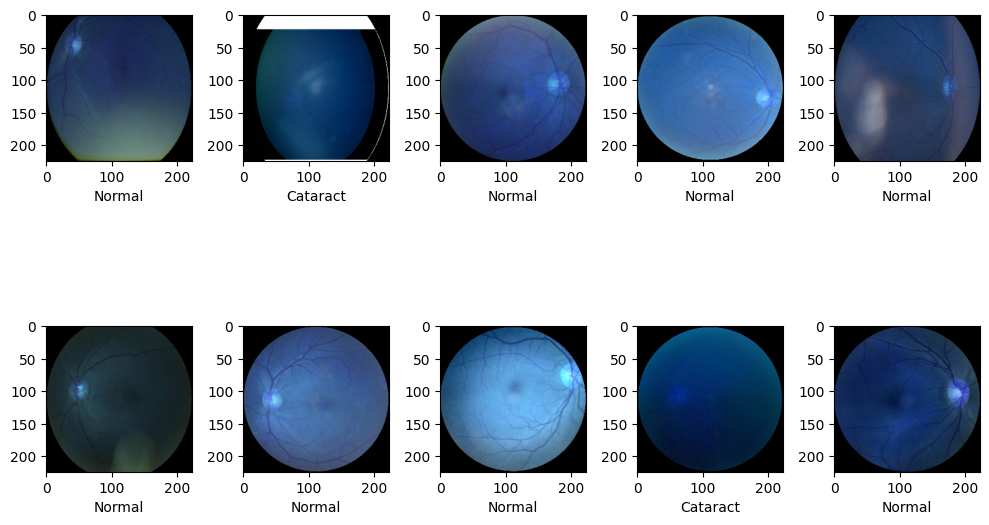

In [ ]:
# Plot a sample of images from the dataset
plt.figure(figsize=(10, 7))
for i in range(0, 10):
    r = range(0, len(dataset))
    sample = random.choice(r)
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category == 0:
      label = "Normal"
    else:
      label = "Cataract"
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()


In [ ]:
# Split the dataset into features (x) and labels (y)
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in dataset])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


(512, 512, 3)
1126_right.jpg


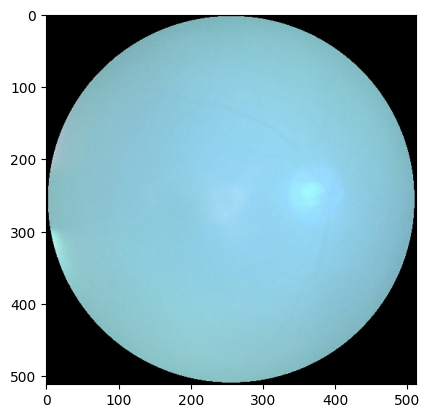

In [ ]:
img = df_c_files[312]
image = cv2.imread(os.path.join(dataset_dir, img))
plt.imshow(image)
print(image.shape)
print(img)

In [ ]:
import time

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [ ]:
  for layer in vgg.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:

# Start the timer
start_time = time.time()

Epoch 1/5
60/60 [==============================] - ETA: 0s - loss: 0.8925 - accuracy: 0.9311 

60/60 [==============================] - 2016s 34s/step - loss: 0.8925 - accuracy: 0.9311 - val_loss: 0.3045 - val_accuracy: 0.9496
Epoch 2/5
60/60 [==============================] - ETA: 0s - loss: 0.1422 - accuracy: 0.9779 

60/60 [==============================] - 1933s 32s/step - loss: 0.1422 - accuracy: 0.9779 - val_loss: 0.2291 - val_accuracy: 0.9769
Epoch 3/5
60/60 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9937 

60/60 [==============================] - 1901s 32s/step - loss: 0.0215 - accuracy: 0.9937 - val_loss: 0.1169 - val_accuracy: 0.9748
Epoch 4/5
60/60 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9963 

60/60 [==============================] - 1891s 32s/step - loss: 0.0140 - accuracy: 0.9963 - val_loss: 0.1164 - val_accuracy: 0.9790
Epoch 5/5
60/60 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9974 

15/15 [==============================] - 406s 27s/step - loss: 0.0700 - accuracy: 0.9769
loss: 0.06997902691364288
Accuracy: 0.9768907427787781
15/15 [==============================] - 377s 25s/step - loss: 0.0700 - accuracy: 0.9769
Test Loss: 0.06997902691364288
Test Accuracy: 0.9768907427787781


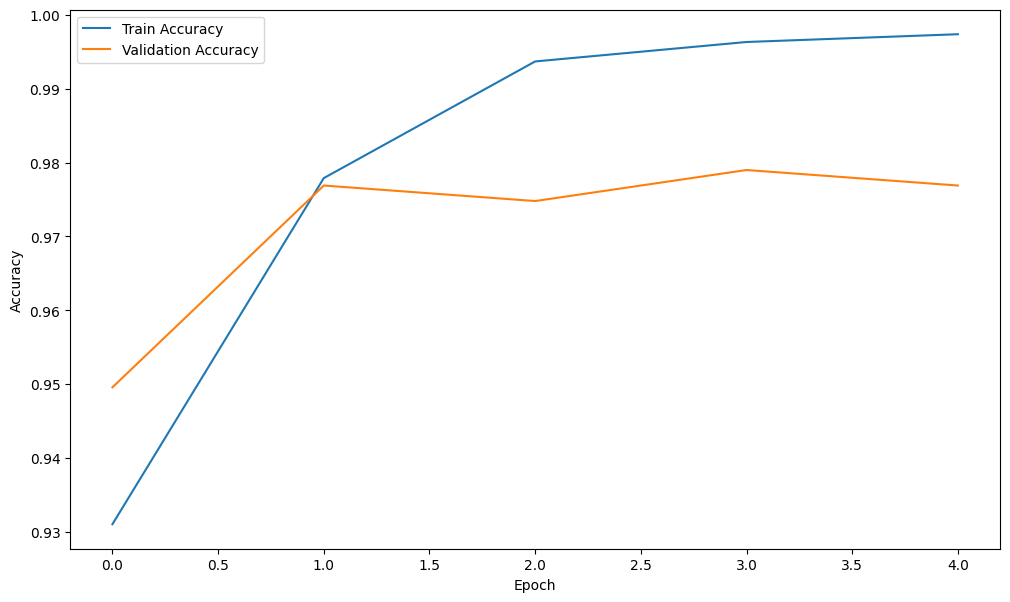

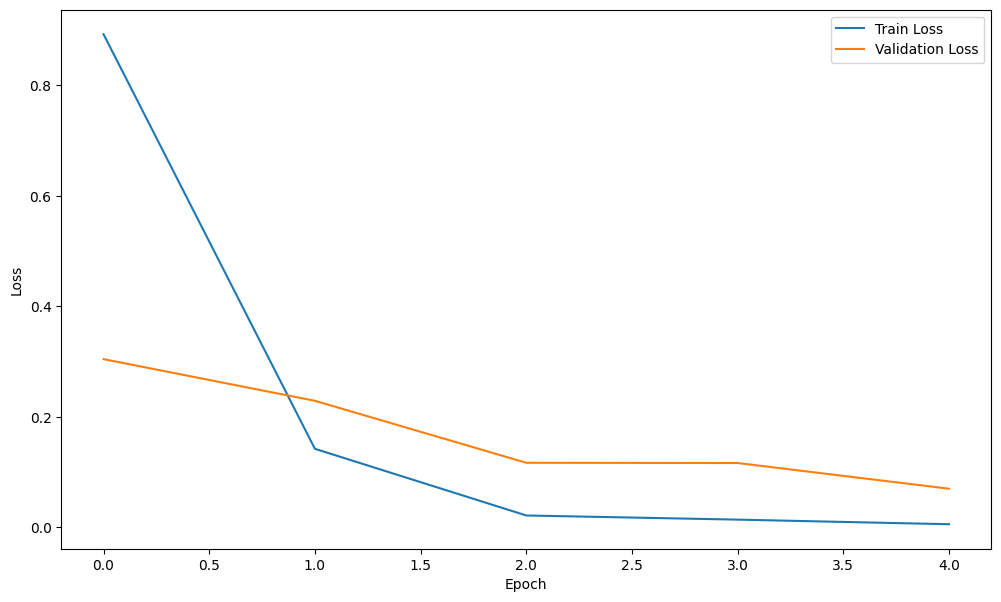

15/15 [==============================] - 374s 25s/step


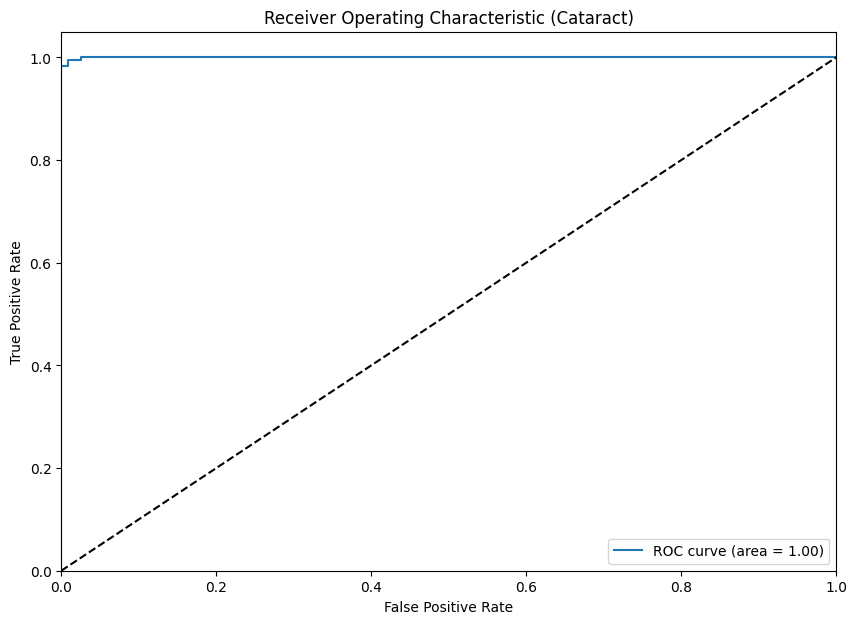

              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98       238
    Cataract       1.00      0.95      0.98       238

    accuracy                           0.98       476
   macro avg       0.98      0.98      0.98       476
weighted avg       0.98      0.98      0.98       476

15/15 [==============================] - 379s 25s/step - loss: 0.0700 - accuracy: 0.9769
Test Loss: 0.06997902691364288
Test Accuracy: 0.9768907427787781


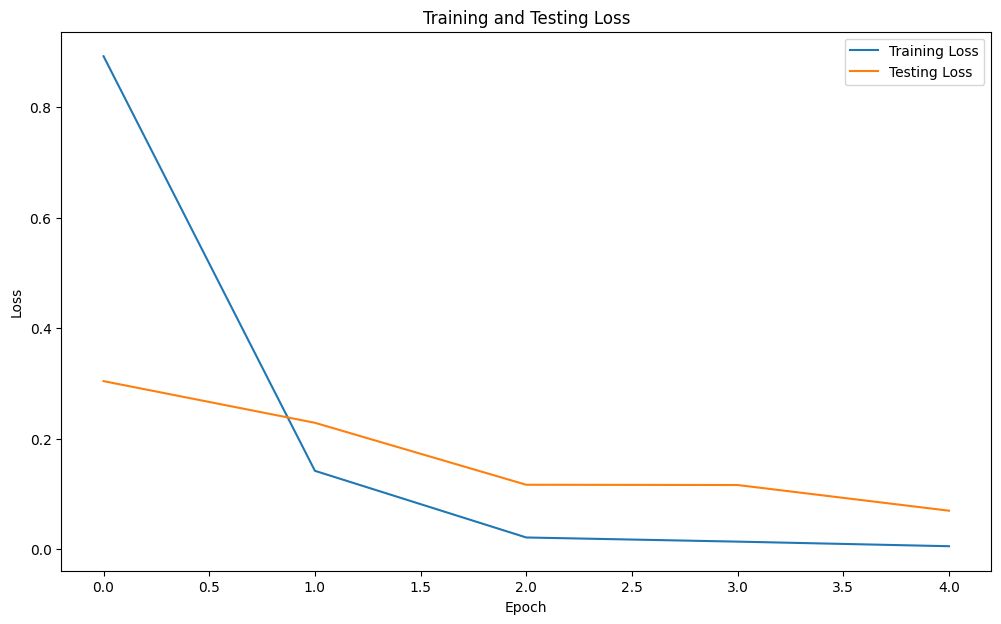

Training Time: 11275.719124794006 seconds


In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)
history = model.fit(x_train,y_train,batch_size=32,epochs=5,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Plot the training history
plt.figure(figsize=(12, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate predictions on the testing set
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Convert labels to binary format
y_test_binary = label_binarize(y_test, classes=[0, 1])
y_pred_proba = y_pred

# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for cataract class
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Cataract)')
plt.legend(loc="lower right")
plt.show()

# Generate classification report
target_names = ['Normal', 'Cataract']
classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
print(classification_rep)

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print('Training Time:', training_time, 'seconds')


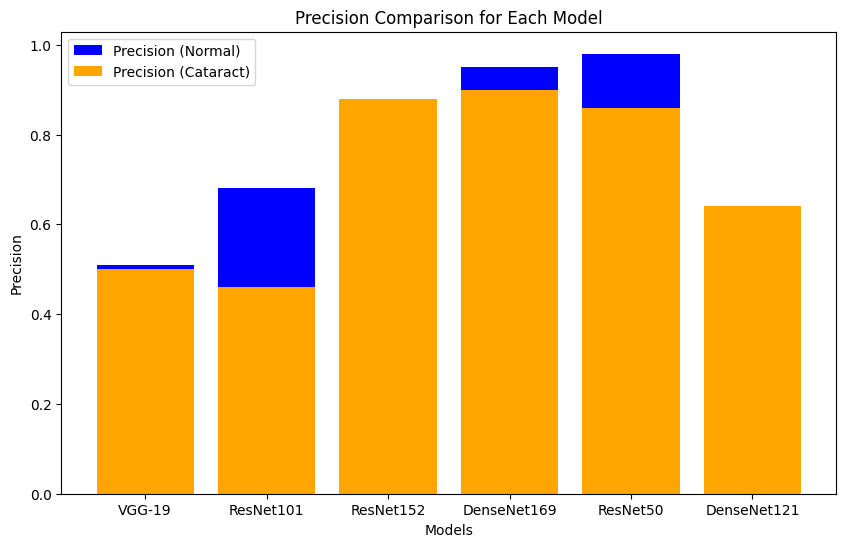

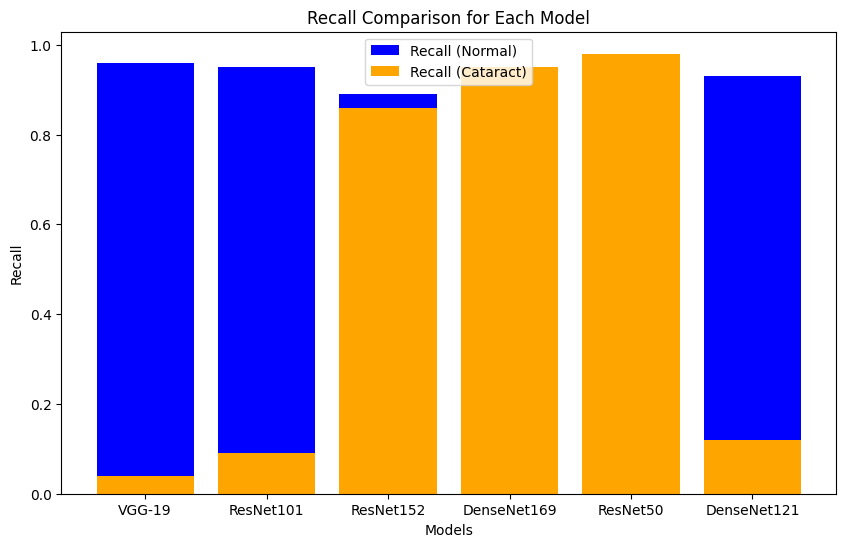

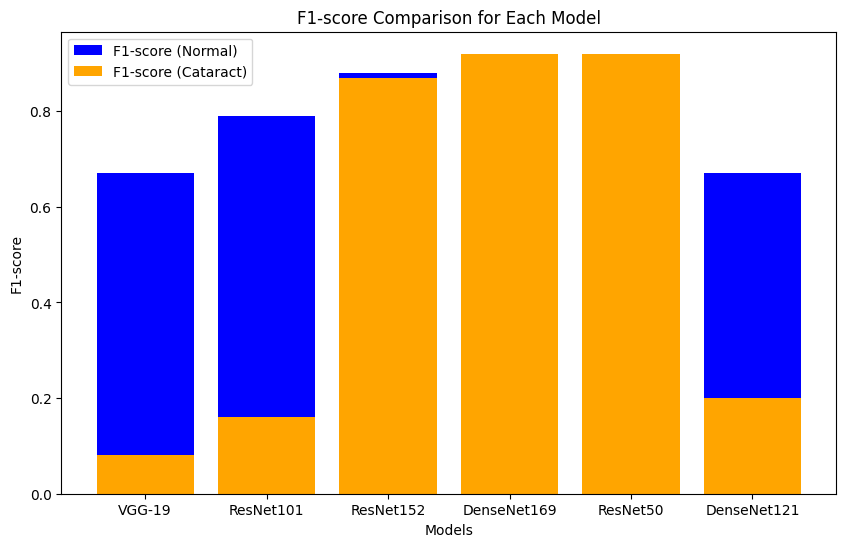

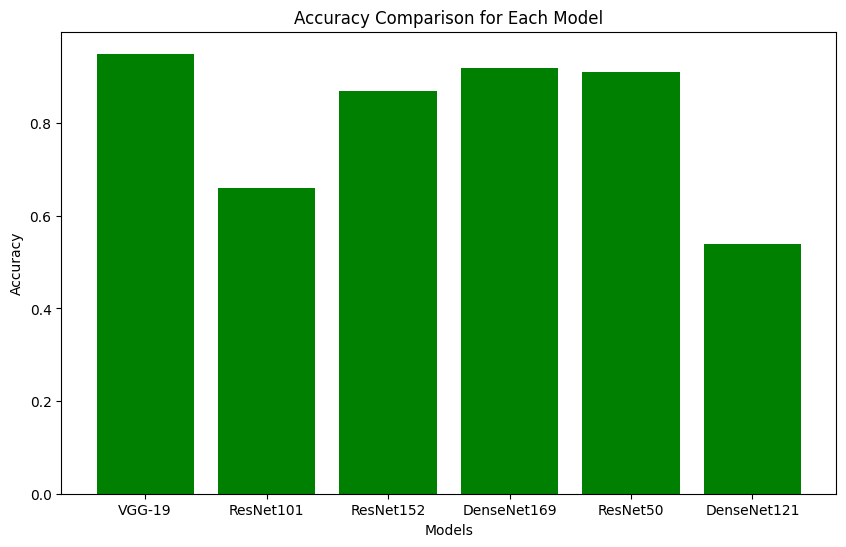

In [ ]:
import matplotlib.pyplot as plt

models = ['VGG-19', 'ResNet101', 'ResNet152', 'DenseNet169', 'ResNet50', 'DenseNet121']
precision_normal = [0.51, 0.68, 0.87, 0.95, 0.98, 0.53]
precision_cataract = [0.50, 0.46, 0.88, 0.90, 0.86, 0.64]
recall_normal = [0.96, 0.95, 0.89, 0.90, 0.84, 0.93]
recall_cataract = [0.04, 0.09, 0.86, 0.95, 0.98, 0.12]
f1_score_normal = [0.67, 0.79, 0.88, 0.92, 0.91, 0.67]
f1_score_cataract = [0.08, 0.16, 0.87, 0.92, 0.92, 0.20]
accuracy = [0.95, 0.66, 0.87, 0.92, 0.91, 0.54]

# Plotting precision
plt.figure(figsize=(10, 6))
plt.bar(models, precision_normal, label='Precision (Normal)', color='blue')
plt.bar(models, precision_cataract, label='Precision (Cataract)', color='orange')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Precision Comparison for Each Model')
plt.legend()
plt.show()

# Plotting recall
plt.figure(figsize=(10, 6))
plt.bar(models, recall_normal, label='Recall (Normal)', color='blue')
plt.bar(models, recall_cataract, label='Recall (Cataract)', color='orange')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Recall Comparison for Each Model')
plt.legend()
plt.show()

# Plotting F1-score
plt.figure(figsize=(10, 6))
plt.bar(models, f1_score_normal, label='F1-score (Normal)', color='blue')
plt.bar(models, f1_score_cataract, label='F1-score (Cataract)', color='orange')
plt.xlabel('Models')
plt.ylabel('F1-score')
plt.title('F1-score Comparison for Each Model')
plt.legend()
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, color='green')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison for Each Model')
plt.show()


In [ ]:
# Save the trained model
model.save('/content/gdrive/MyDrive/Ocular_Disease_Recognition/model.h5')
print('Model saved.')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved.


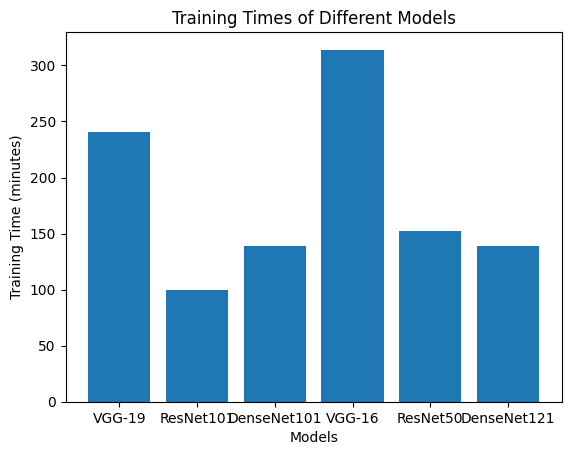

In [ ]:
import matplotlib.pyplot as plt

models = ['VGG-19', 'ResNet101', 'DenseNet101', 'VGG-16', 'ResNet50', 'DenseNet121']
training_times = [241, 100, 139, 314, 152, 139]

plt.bar(models, training_times)
plt.xlabel('Models')
plt.ylabel('Training Time (minutes)')
plt.title('Training Times of Different Models')
plt.show()


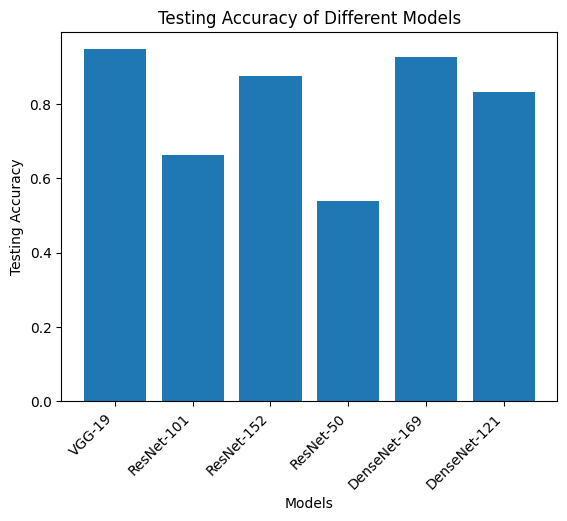

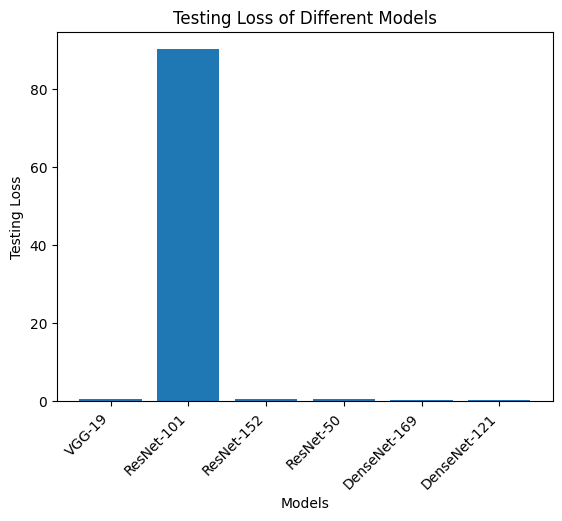

In [ ]:
import matplotlib.pyplot as plt

models = ['VGG-19', 'ResNet-101', 'ResNet-152', 'ResNet-50', 'DenseNet-169', 'DenseNet-121']
test_accuracy = [0.9453781247138977, 0.6632124185562134, 0.8739495873451233, 0.5378151535987854, 0.924369752407074, 0.831932783126831]
test_loss = [0.6909425854682922, 90.07926177978516, 0.5370689630508423, 0.6906895637512207, 0.33850857615470886, 0.4863419830799103]

plt.bar(models, test_accuracy)
plt.xlabel('Models')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy of Different Models')

# Adjust the gap between the labels on the X-axis
plt.xticks(rotation=45, ha='right')

plt.show()

plt.bar(models, test_loss)
plt.xlabel('Models')
plt.ylabel('Testing Loss')
plt.title('Testing Loss of Different Models')

# Adjust the gap between the labels on the X-axis
plt.xticks(rotation=45, ha='right')

plt.show()


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set the image size
image_size = 224

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# Instantiate VGG19 model
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

# Freeze the layers of the pre-trained VGG19 model
for layer in vgg.layers:
    layer.trainable = False

# Create a sequential model
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

model.summary()

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Set up cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Start the timer
start_time = time.time()

# Perform cross-validation
fold = 1
for train_index, val_index in kfold.split(x_train, y_train):
    print(f"Fold: {fold}")
    fold += 1

    # Split data into training and validation sets
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Set up callbacks
    checkpoint = ModelCheckpoint(f"vgg19_fold{fold}.h5", monitor="val_accuracy", verbose=1,
                                 save_best_only=True, save_weights_only=False, period=1)
    earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)

    # Train the model on the current fold
    history = model.fit(x_train_fold, y_train_fold, batch_size=32, epochs=5,
                        validation_data=(x_val_fold, y_val_fold), verbose=1,
                        callbacks=[checkpoint, earlystop])

    # Evaluate the model on the current fold
    loss, accuracy = model.evaluate(x_val_fold, y_val_fold)
    print("Validation Loss:", loss)
    print("Validation Accuracy:", accuracy)

    # Generate predictions on the testing set
    y_pred = model.predict(x_test)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Generate classification report
    target_names = ['Normal', 'Cataract']
    classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
    print(classification_rep)

    # Plot the ROC curve for the current fold
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (Fold {fold})')
    plt.legend(loc="lower right")
    plt.show()

# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print('Training Time:', training_time, 'seconds')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________
Fold: 1


Epoch 1/5
48/48 [==============================] - ETA: 0s - loss: 1.7717 - accuracy: 0.8921 
Epoch 1: val_accuracy improved from -inf to 0.93947, saving model to vgg19_fold2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 1534s 32s/step - loss: 1.7717 - accuracy: 0.8921 - val_loss: 0.5370 - val_accuracy: 0.9395
Epoch 2/5
34/48 [====================>.........] - ETA: 5:56 - loss: 0.1924 - accuracy: 0.9761